In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import os
import time
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:

# === 1. Load Data ===
fichier_prices = "DS_RI_T_USD_M.xlsx"
fichier_caps = "DS_MV_T_USD_M.xlsx"
risk_free = pd.read_excel("Risk_Free_Rate.xlsx", index_col=0)
static_file = "Static.xlsx"


df_prices = pd.read_excel(fichier_prices)
df_caps = pd.read_excel(fichier_caps)


In [ ]:
# Use ISIN as index
df_prices.set_index(df_prices.columns[0], inplace=True)
df_caps.set_index(df_caps.columns[0], inplace=True)

# Filter and clean price data (adjust columns as needed)
prix_df = df_prices.iloc[:, 3:]
prix_df.columns = pd.to_datetime(prix_df.columns)
df_prices = prix_df

# Calculate monthly returns and clean problematic values
returns = df_prices.pct_change(axis=1, fill_method=None).dropna(how='all')
# Clean returns data - replace infinities with NaN and clip to reasonable range
returns = returns.replace([np.inf, -np.inf], np.nan).infer_objects()  # Fix FutureWarning
max_valid_return = 10  # 1000% as maximum reasonable return
returns = returns.clip(lower=-max_valid_return, upper=max_valid_return)



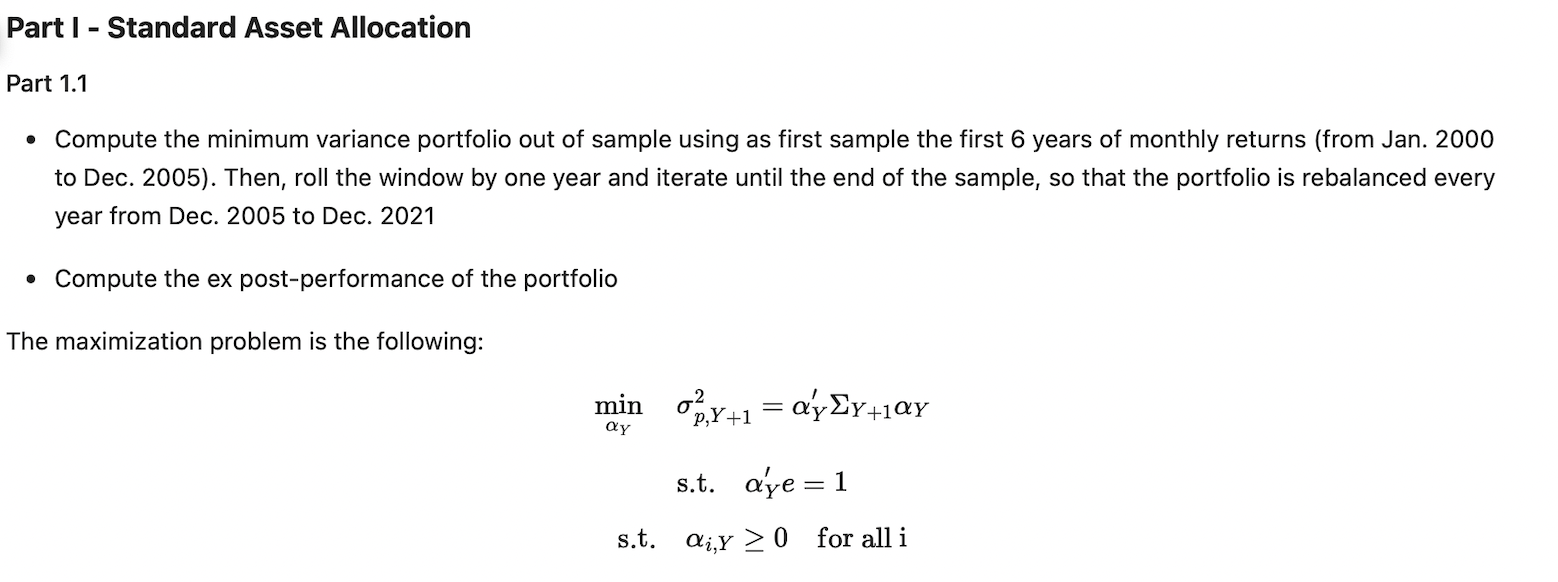

In [ ]:

# Function to calculate expected returns and covariance matrix with NaN/Inf handling
def calculate_mean_cov_safe(df, start, end):
    sample = df.loc[:, (df.columns >= start) & (df.columns < end)]
    sample = sample.dropna(how='all', axis=0)  # Drop assets without data in this window
    sample = sample.dropna(axis=1, how='any')  # Drop columns with NaNs in the window

    # Calculate expected returns
    expected_returns = sample.mean(axis=1)

    # Calculate excess returns
    excess_returns = sample.sub(expected_returns, axis=0)

    # Calculate covariance matrix
    cov_matrix = (excess_returns @ excess_returns.T) / (sample.shape[1] - 1)

    # Ensure no NaNs or Infs
    cov_matrix = np.nan_to_num(cov_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    return expected_returns, cov_matrix, sample.index

# Objective Function (Minimize Portfolio Variance)
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraint: Sum of weights must equal 1
def full_investment_constraint(weights):
    return np.sum(weights) - 1

# === 3. Portfolio Optimization ===

# DataFrame to store optimal weights
weights_df = pd.DataFrame(index=df_prices.index)

# Rolling Window Optimization (Out-of-Sample)
start_year = 2004
end_year = 2013

for year in range(2014, 2024 + 1):
    print(f"\nOptimizing for year: {year}")

    # Define the start and end of the 10-year window
    start = pd.Timestamp(f'{start_year}-01-01')
    end = pd.Timestamp(f'{end_year}-12-31')

    # Calculate expected returns and covariance matrix with safety
    mu_hat, covmat, valid_assets = calculate_mean_cov_safe(returns, start, end)

    # Regularize the covariance matrix
    covmat += np.eye(len(covmat)) * 1e-6

    # Adjust initial weights to match valid assets
    valid_weights = np.ones(len(valid_assets)) / len(valid_assets)

    # Perform optimization using SLSQP for efficiency
    result = minimize(
        portfolio_variance,
        valid_weights,
        args=(covmat,),
        method='SLSQP',
        constraints={'type': 'eq', 'fun': full_investment_constraint},
        bounds=[(0, 1)] * len(valid_assets),
        options={'maxiter': 500, 'disp': False}
    )

    # Save the optimal weights (aligning with all assets)
    optimal_weights = pd.Series(0, index=df_prices.index)  # Initialize with zeros
    if result.success:
        optimal_weights.loc[valid_assets] = result.x
        print(f"Optimization succeeded for {year}.")
    else:
        print(f"Optimization failed for {year}: {result.message}")

    weights_df[str(year)] = optimal_weights  # Convert year to string for consistent column types

    # Roll the window forward
    start_year += 1
    end_year += 1

# === 4. Save the Optimized Weights to Excel ===

# Save the optimized weights to an Excel file for easy review
output_file = "Optimized_Weights_SAAM_Project_Fast.xlsx"
weights_df.to_excel(output_file, index=True)
print(f"Optimized weights saved to {output_file}")

# === 5. View the Weights in Excel ===

# Load the Excel file
weights_df = pd.read_excel(output_file, index_col=0)

# Displaying the first few rows of the table
print(weights_df.head())

In [ ]:

# === 6. Constraint Checking ===
def check_constraints(weights_df):
    if (np.round(weights_df.sum(axis=0), 6) == 1).all():
        print('No error: Full investment constraint has been correctly applied.')
    else:
        print('Error: Full investment constraint has not been correctly applied. Try again!')

    if (weights_df.min().min() >= 0) & (weights_df.max().max() <= 1):
        print('No error: Long Only Constraint has been correctly applied.')
    else:
        print('Error: Long Only Constraint has not been correctly applied. Try again!')


# Check constraints for the optimized weights
check_constraints(weights_df)


In [ ]:

# === 7. Transforming Weights to Alphas (Intermediate Weights) - CORRECTED ===
def from_weights_to_alphas(weights_df):
    alphas_df = pd.DataFrame()

    # Ensure weights_df columns are strings
    weights_df.columns = weights_df.columns.astype(str)

    for year in range(2014, 2024):
        year_str = str(year)  # Convert to string for consistent column access

        # Extract the actual dates from the returns for the year
        returns_subdf = returns.loc[:, (returns.columns >= f'{year}-01-01') & (returns.columns <= f'{year}-12-31')]
        actual_dates = returns_subdf.columns

        # Create an alpha dataframe using the actual dates from returns
        alpha_subdf = pd.DataFrame(index=weights_df.index, columns=actual_dates)
        alpha_subdf.iloc[:, 0] = weights_df[year_str]  # Use string year for column access

        # Align the stocks in alpha_subdf with the returns_subdf
        alpha_subdf = alpha_subdf.loc[alpha_subdf.index.intersection(returns_subdf.index)]

        # Complete the alpha_subdf using monthly returns
        for date in range(1, alpha_subdf.shape[1]):
            for stock in alpha_subdf.index:
                if stock in returns_subdf.index:
                    # Get stock return, handling NaN and Inf
                    stock_ret = returns_subdf.loc[stock, actual_dates[date]] if date < len(actual_dates) else 0
                    if pd.isna(stock_ret) or np.isinf(stock_ret):
                        stock_ret = 0  # Replace NaN/Inf with 0

                    # Calculate portfolio return, handling NaN and Inf
                    pf_ret_series = alpha_subdf.iloc[:, date - 1] * returns_subdf.loc[:, actual_dates[date - 1]]
                    # Fix FutureWarning by using infer_objects without copy parameter
                    pf_ret_series = pf_ret_series.replace([np.inf, -np.inf], np.nan).infer_objects().dropna()
                    pf_ret = pf_ret_series.sum()

                    # Ensure pf_ret is not too small to avoid extreme values
                    if pd.isna(pf_ret) or abs(pf_ret) < 1e-4:
                        pf_ret = 1e-4 if pf_ret >= 0 else -1e-4

                    # Update alpha only if the previous value is valid
                    prev_alpha = alpha_subdf.loc[stock, actual_dates[date - 1]]
                    if (not pd.isna(prev_alpha) and np.isfinite(prev_alpha) and
                        np.isfinite(stock_ret) and np.isfinite(pf_ret)):

                        # Calculate updated alpha with safeguards
                        updated_alpha = prev_alpha * ((1 + stock_ret) / (1 + pf_ret))

                        # Clip to reasonable range to prevent extreme values
                        alpha_subdf.loc[stock, actual_dates[date]] = np.clip(updated_alpha, -10, 10)

        # Forward fill missing dates in alphas and fix FutureWarning
        alpha_subdf = alpha_subdf.ffill(axis=1)
        alpha_subdf = alpha_subdf.fillna(0)
        alpha_subdf = alpha_subdf.infer_objects().astype(float)

        alphas_df = pd.concat([alphas_df, alpha_subdf], axis=1)

    return alphas_df


# Convert the optimized weights to alphas
alphas_df = from_weights_to_alphas(weights_df)
print("\nAlphas DataFrame created.")


# === 8. Calculate Portfolio Performance - CORRECTED ===
def from_alphas_to_perf(alphas_df):
    # Align dates between alphas and returns
    returns_subdf = returns.loc[:, (returns.columns >= '2014-01-01') & (returns.columns <= '2024-12-31')]
    aligned_dates = returns_subdf.columns

    # Check for missing dates
    missing_dates = set(aligned_dates) - set(alphas_df.columns)
    if missing_dates:
        print(f"\n Missing Dates in Alphas: {missing_dates}")

    # Ensure the columns match exactly (align them)
    aligned_alphas_df = alphas_df.reindex(columns=aligned_dates).ffill(axis=1).fillna(0)
    aligned_alphas_df = aligned_alphas_df.infer_objects()  # Fix FutureWarning

    # Create a list to store the portfolio performance for each month
    performances = []

    # Calculate portfolio performance for each month
    for date in aligned_dates:
        if date in aligned_alphas_df.columns:
            # Get alphas and returns for this date
            aligned_alphas = aligned_alphas_df.loc[:, date].fillna(0)
            aligned_returns = returns_subdf.loc[:, date].fillna(0)

            # Ensure indices are aligned (critical fix)
            common_indices = aligned_alphas.index.intersection(aligned_returns.index)
            if len(common_indices) == 0:
                print(f"No common indices for date {date}, skipping")
                performances.append(0)
                continue

            aligned_alphas = aligned_alphas.loc[common_indices]
            aligned_returns = aligned_returns.loc[common_indices]

            # Calculate performance using dot product on aligned data
            try:
                raw_perf = aligned_alphas.dot(aligned_returns)

                # Handle both scalar and Series results
                if isinstance(raw_perf, (pd.Series, np.ndarray)):
                    # If it's a Series or array, clip values and take the sum
                    perf = np.clip(raw_perf, -100, 100).sum()
                else:
                    # If it's a scalar, just clip it
                    perf = np.clip(raw_perf, -100, 100)

                performances.append(perf)
            except Exception as e:
                print(f"Error calculating performance for {date}: {e}")
                performances.append(0)

    # Convert to a pandas Series
    return pd.Series(performances, index=aligned_dates)


# Calculate the portfolio performance using the alphas
performances = from_alphas_to_perf(alphas_df)
print("\nPortfolio Performance Calculated.")


performances.to_csv("performances.csv", index=True)

In [ ]:

# === 9. Portfolio Characteristics - CORRECTED FOR SHARPE RATIO ===
def pf_characteristics(performances, risk_free, name, output_file=None):
    # Monthly average return
    avg_m_ret = performances.mean()

    # Annualized average return
    avg_y_ret = 12 * avg_m_ret

    # Monthly volatility
    m_vol = performances.std()

    # Ensure volatility is not zero to avoid division issues
    if m_vol == 0 or pd.isna(m_vol):
        m_vol = 1e-6  # Small non-zero value

    # Annualized volatility
    y_vol = np.sqrt(12) * m_vol

    # Get the average risk-free rate for each month in performances
    rf_values = []
    for date in performances.index:
        year_month = date.strftime('%Y%m')
        try:
            # Try direct lookup by YYYYMM format
            rf_value = risk_free.loc[risk_free.index == int(year_month), 'RF'].values[0] / 100
            rf_values.append(rf_value)
        except (IndexError, ValueError):
            # If direct lookup fails, find the closest earlier date
            try:
                date_int = int(date.strftime('%Y%m'))
                mask = risk_free.index <= date_int
                if mask.any():
                    closest_idx = risk_free[mask].index.max()
                    rf_values.append(risk_free.loc[closest_idx, 'RF'] / 100)
                else:
                    # If no earlier date exists, use the earliest available
                    rf_values.append(risk_free.iloc[0]['RF'] / 100)
            except Exception as e:
                print(f'Warning: Error finding risk-free rate for {date}: {e}')
                rf_values.append(0.001)  # Default value

    # Create a Series with the same index as performances
    rf_series = pd.Series(rf_values, index=performances.index)

    # Monthly Sharpe Ratio (with safety checks)
    excess_returns = performances - rf_series
    sharpe_m = excess_returns.mean() / m_vol

    # Annualized Sharpe Ratio
    sharpe_y = np.sqrt(12) * sharpe_m

    # Minimum, Maximum, and Maximum Drawdown
    minimum = performances.min()
    maximum = performances.max()

    # Compute the Maximum Drawdown with safety checks
    cum_ret = (1 + performances).cumprod()
    peaks = cum_ret.cummax()

    # Avoid division by zero in drawdown calculation
    drawdowns = (cum_ret - peaks) / peaks.replace(0, 1e-6)
    MDD = drawdowns.min()

    # Create a DataFrame for the characteristics
    data = {
        'Annualized Average Return': [avg_y_ret],
        'Annualized Volatility': [y_vol],
        'Sharpe Ratio': [sharpe_y],
        'Minimum': [minimum],
        'Maximum': [maximum],
        'Maximum Drawdown': [MDD]
    }

    result = pd.DataFrame(data, index=[name]).T

    # Print debugging info
    print(f"Annualized Average Return: {avg_y_ret}")
    print(f"Annualized Volatility: {y_vol}")
    print(f"Sharpe Ratio: {sharpe_y}")
    print(f"Minimum: {minimum}")
    print(f"Maximum: {maximum}")
    print(f"Maximum Drawdown: {MDD}")

    # Save to Excel
    if output_file:
        result.to_excel(output_file)

    return result


pf_characteristics(performances, risk_free, "pmv", output_file="characteristics_output.xlsx")



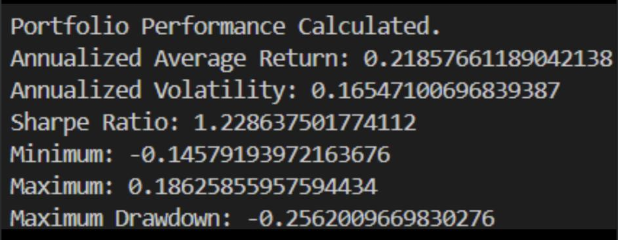

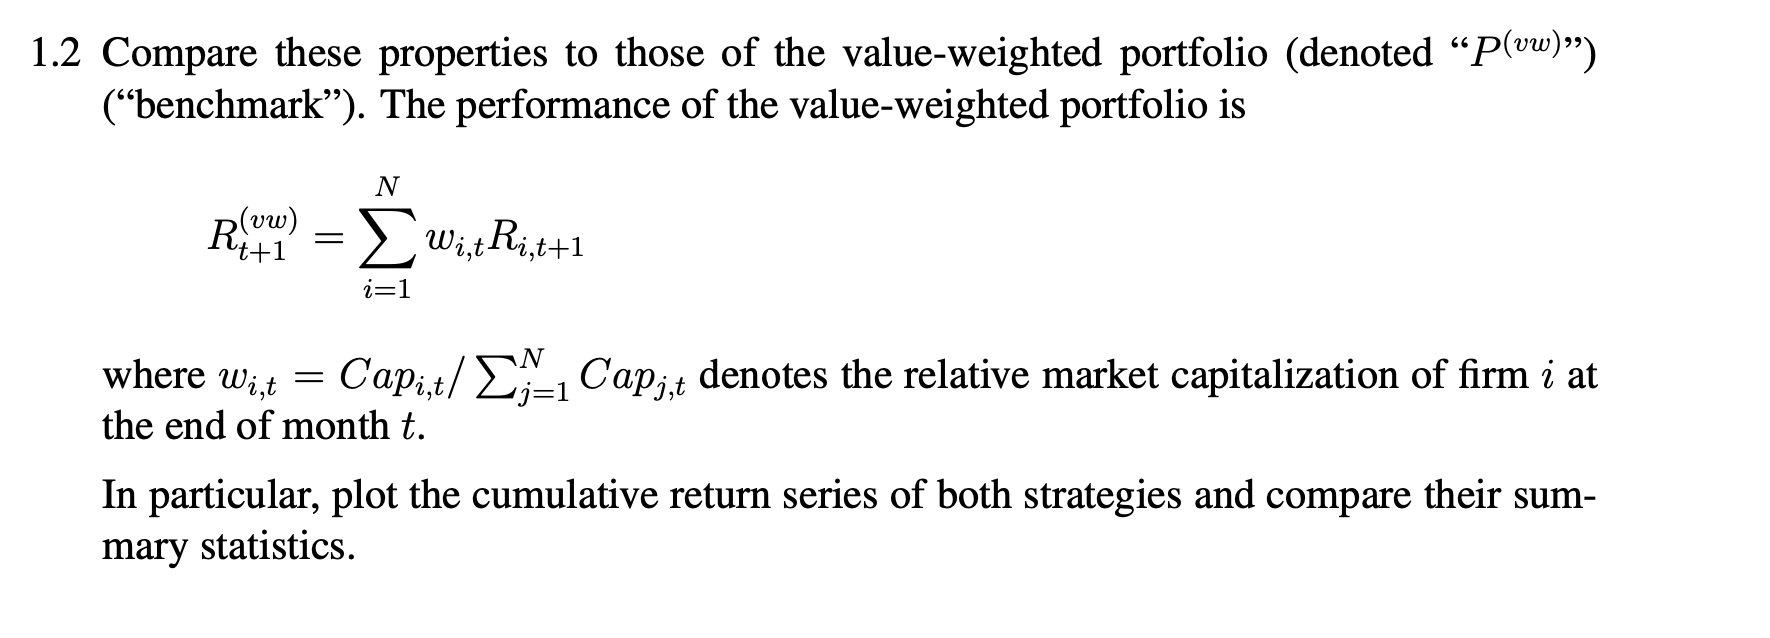

In [ ]:
companies = pd.read_excel(static_file)

# Mise en forme et filtre EM
df_caps = df_caps.set_index('ISIN')
df_caps = df_caps.drop(columns=['NAME'])
df_caps = df_caps.apply(pd.to_numeric, errors='coerce')
df_caps.columns = pd.to_datetime(df_caps.columns).strftime('%Y-%m')
df_caps = df_caps.dropna(axis=0, how='any')

companies_em = companies[companies["Region"] == "EM"]
isin_em = set(companies_em["ISIN"])
df_caps = df_caps[df_caps.index.isin(isin_em)]

print("Shape après nettoyage et filtre EM :", df_caps.shape)

# === 2. Calcul des rendements mensuels ===
start_month = '2004-01'
end_month = '2024-12'
df_caps = df_caps.loc[:, (df_caps.columns >= start_month) & (df_caps.columns <= end_month)]
simple_returns = df_caps.pct_change(axis=1, fill_method=None).iloc[:, 1:]
dates = list(simple_returns.columns)

# === 3. Charger la market cap sur la même période ===
market_value_m = pd.read_excel(fichier_caps)
market_value_m = market_value_m.set_index('ISIN')
market_value_m = market_value_m.drop(columns=['NAME'])
market_value_m = market_value_m.apply(pd.to_numeric, errors='coerce')
market_value_m.columns = pd.to_datetime(market_value_m.columns).strftime('%Y-%m')
market_value_m = market_value_m.loc[df_caps.index, df_caps.columns]

# === 4. Dates du benchmark (alignées sur min-variance, 2014-01 à 2024-12) ===
dates_full = pd.date_range(start='2014-01-01', end='2024-12-31', freq='M').strftime('%Y-%m').tolist()
vw_returns = []

for d in dates_full:
    if d not in simple_returns.columns:
        vw_returns.append(np.nan)
        continue
    idx_prev = simple_returns.columns.get_loc(d) - 1
    if idx_prev < 0:
        vw_returns.append(np.nan)
        continue
    date_prev = simple_returns.columns[idx_prev]
    caps = market_value_m[date_prev]
    rets = simple_returns[d]
    weights = caps / caps.sum()
    vw_returns.append(np.nansum(weights * rets))

assert len(vw_returns) == len(dates_full)

perf_df = pd.DataFrame({
    "Date": dates_full,
    "ValueWeighted Return": vw_returns
})

# === 5. Stats et plot ===
perf_df["Cumulative VW"] = (1 + perf_df["ValueWeighted Return"].fillna(0)).cumprod() - 1

vw_ret_array = np.array(perf_df["ValueWeighted Return"])
vw_ret_array = vw_ret_array[~np.isnan(vw_ret_array)]
vw_mu_annual = np.mean(vw_ret_array) * 12
vw_sigma_annual = np.std(vw_ret_array, ddof=1) * np.sqrt(12)
vw_sharpe = vw_mu_annual / vw_sigma_annual if vw_sigma_annual > 0 else np.nan

print("\n=== Value-Weighted Portfolio (out-of-sample, EM uniquement) ===")
print(f"Moyenne annualisée : {vw_mu_annual:.4%}")
print(f"Volatilité annualisée : {vw_sigma_annual:.4%}")
print(f"Sharpe ratio : {vw_sharpe:.3f}")
print(f"Min mensuel : {vw_ret_array.min():.4%}")
print(f"Max mensuel : {vw_ret_array.max():.4%}")

plt.figure(figsize=(10,6))
plt.plot(perf_df["Date"], perf_df["Cumulative VW"], label="Value Weighted Portfolio")
plt.title("Cumulative Return of Value Weighted Portfolio (EM Only)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

perf_df.to_csv("value_weighted_portfolio_EM.csv", index=False)

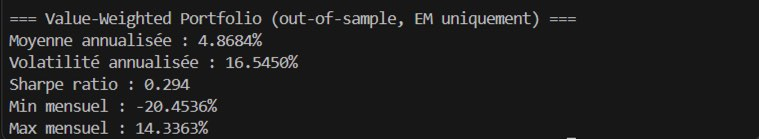

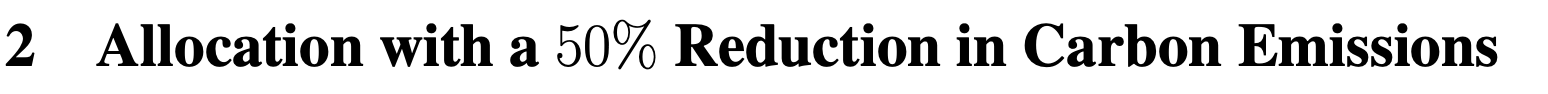

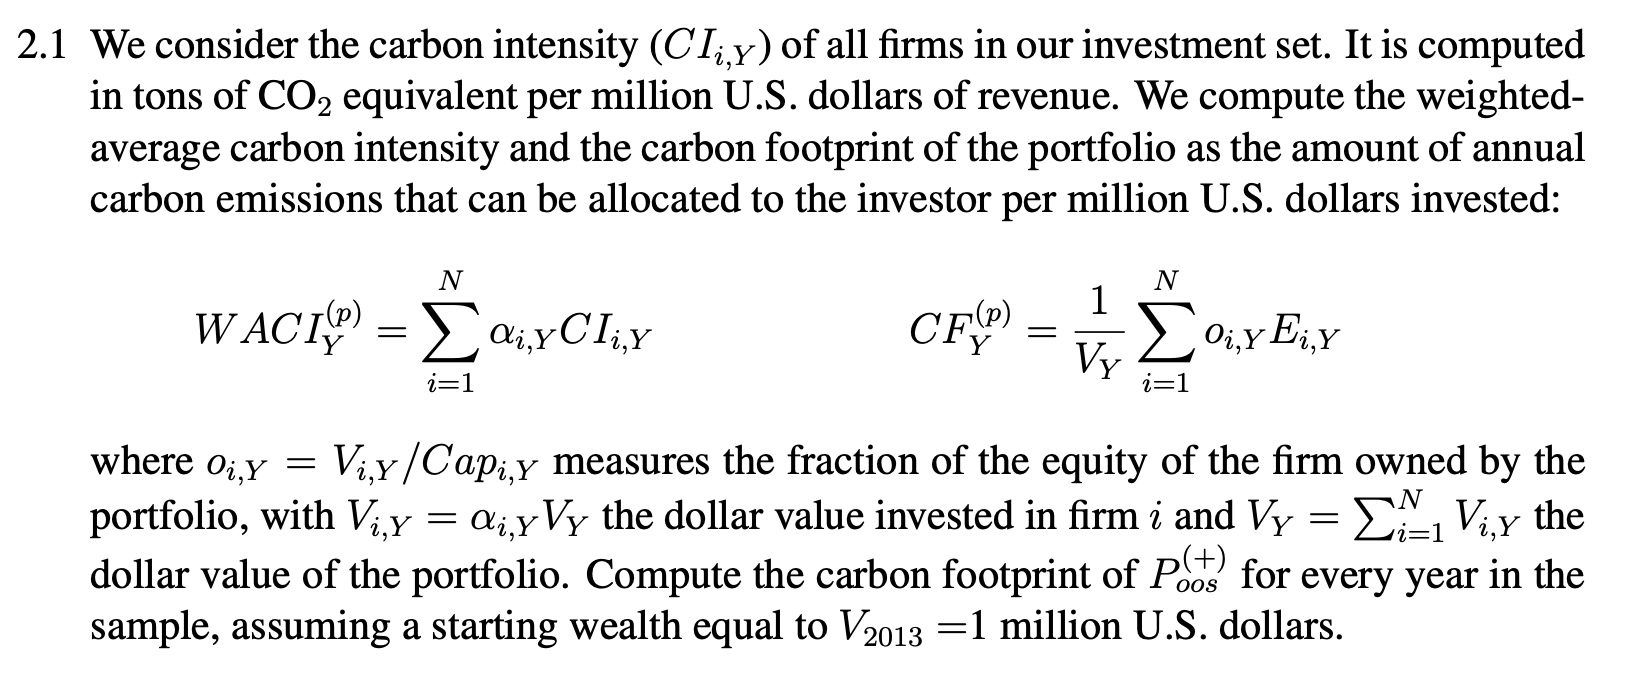

In [ ]:

weights_file = "Optimized_Weights_SAAM_Project_Fast.xlsx"
scope1_file = "Scope_1.xlsx"
revenues_file = "DS_REV_USD_Y.xlsx"
marketcap_file = "DS_MV_T_USD_Y.xlsx"
static_file = "Static.xlsx"

# === Load Data ===
weights = pd.read_excel(weights_file, index_col=0)
scope1 = pd.read_excel(scope1_file, index_col=0)
revenues = pd.read_excel(revenues_file, index_col=0)
marketcap = pd.read_excel(marketcap_file, index_col=0)
static = pd.read_excel(static_file)

# === Debug Column Types ===
print("Weights columns types:", [type(col) for col in weights.columns])
print("Scope1 columns types:", [type(col) for col in scope1.columns])
print("Revenues columns types:", [type(col) for col in revenues.columns])
print("Marketcap columns types:", [type(col) for col in marketcap.columns])

# === Helper Function for Robust Column Access ===
def get_column_data(df, year):
    """Access DataFrame column with robust type handling for year columns"""
    if year in df.columns:
        return df[year]
    elif str(year) in df.columns:
        return df[str(year)]
    else:
        print(f"Warning: Year {year} not found in columns: {df.columns}")
        return pd.Series(index=df.index)

# === Harmonize Index Names (Mapping to ISIN) ===
name_to_isin = dict(zip(static["Name"].astype(str).str.upper(), static["ISIN"]))

def map_index_to_isin(df):
    if all(df.index.str.len() == 12):
        return df
    df['ISIN'] = df.index.astype(str).str.upper().map(name_to_isin)
    df.dropna(subset=['ISIN'], inplace=True)
    df.set_index('ISIN', inplace=True)
    # Remove duplicates after mapping to ensure unique indices
    return df[~df.index.duplicated(keep='first')]

scope1 = map_index_to_isin(scope1)
revenues = map_index_to_isin(revenues)
marketcap = map_index_to_isin(marketcap)

# === Clean Data (Prevent Zero or Negative) ===
revenues = revenues.clip(lower=1e-6)
carbon_intensity = scope1 / revenues

# === Remove Duplicate Index Entries ===
weights = weights[~weights.index.duplicated(keep='first')]
scope1 = scope1[~scope1.index.duplicated(keep='first')]
revenues = revenues[~revenues.index.duplicated(keep='first')]
marketcap = marketcap[~marketcap.index.duplicated(keep='first')]

# === WACI and CF Calculation for Part 2.1 ===
V_init = 1_000_000
cf_list_2_1 = []
waci_list = []
for year in years:
    # Ensure common_isins has no duplicates
    common_isins = list(set(weights.index) & set(scope1.index) & set(marketcap.index))
    common_isins = list(dict.fromkeys(common_isins))

    # Create DataFrame with explicit index to avoid reindexing issues
    try:
        w_series = get_column_data(weights, year).loc[common_isins]
        emi_series = get_column_data(scope1, year).loc[common_isins]
        cap_series = get_column_data(marketcap, year).loc[common_isins]
        carbon_intensity_series = get_column_data(carbon_intensity, year).loc[common_isins]
    except Exception as e:
        print(f"Error accessing data for year {year}: {e}")
        cf_list_2_1.append(np.nan)
        continue

    # Create a new index that's guaranteed to be unique
    valid_indices = w_series.index.intersection(emi_series.index).intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['w'] = w_series.loc[valid_indices]
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp['ci'] = carbon_intensity_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    if len(df_tmp) == 0:
        print(f"Warning: No valid data for year {year} in CF calculation 2.1")
        cf_list_2_1.append(np.nan)
        continue

    V_i = df_tmp['w'].values * V_init
    ci = df_tmp['ci'].values
    w = df_tmp['w'].values
    waci = np.sum(w * ci)
    waci_list.append(waci)
    o_i = V_i / df_tmp['cap'].values
    cf = (1 / V_init) * np.nansum(o_i * df_tmp['emi'].values)
    cf_list_2_1.append(cf)
    print(f"CF 2.1 for year {year}: {cf:.2f}")


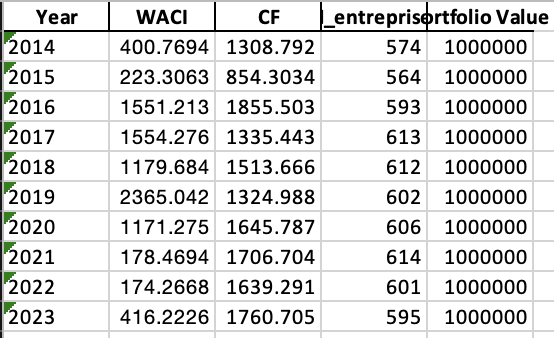

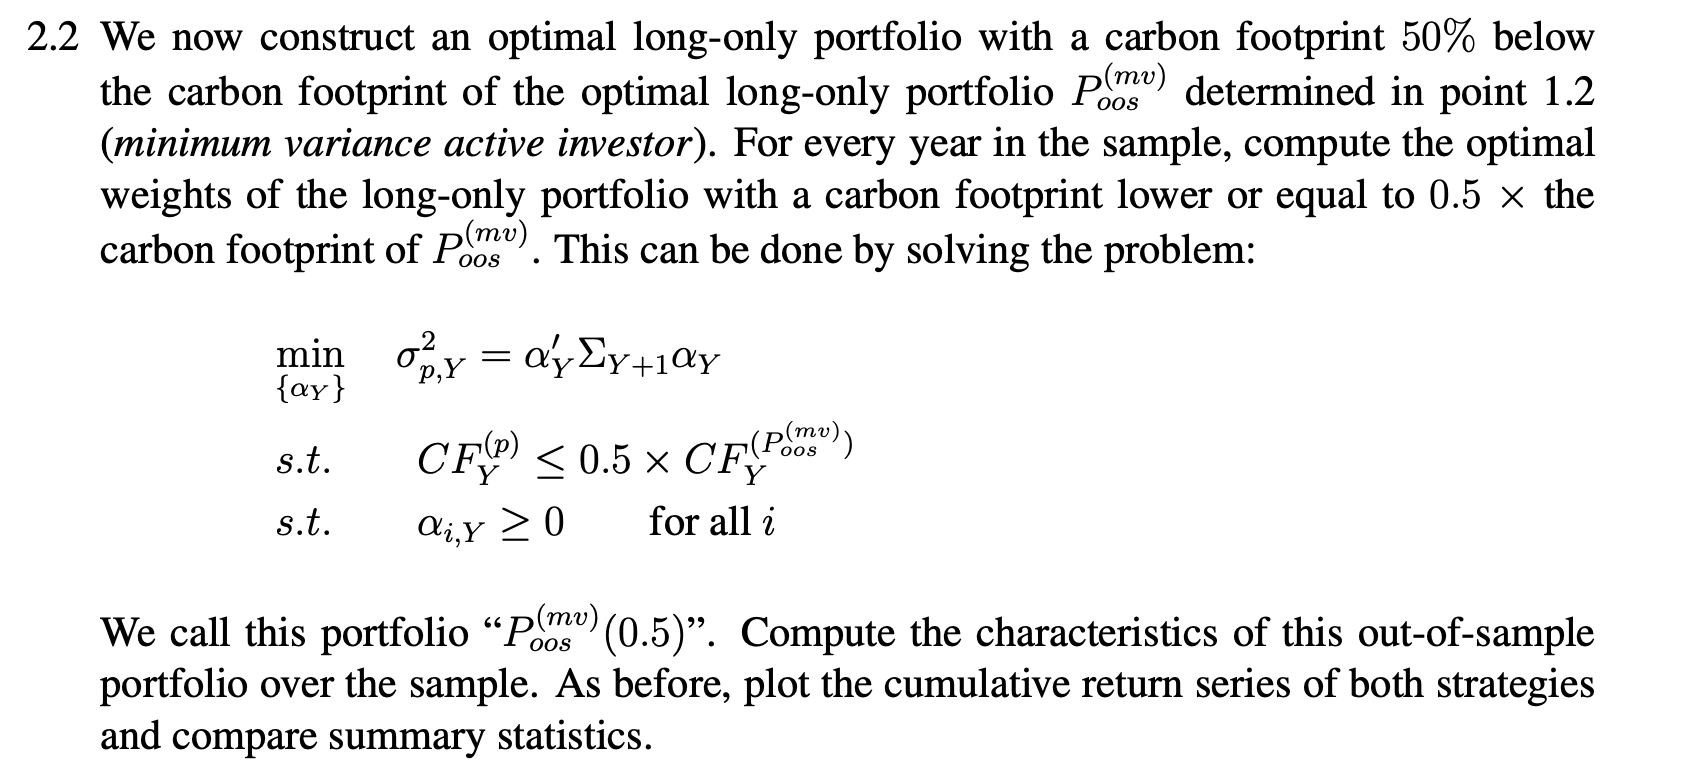

In [ ]:

# === Optimize Weights for Part 2.2 (MV 0.5) ===
V_init = 1_000_000
years = list(range(2014, 2024))  # Use integer years
optimized_weights = pd.DataFrame(index=weights.index, columns=[str(y) for y in years])  # Use string columns for consistency

for year in years:
    # Check if year exists in both scope1 and marketcap
    year_in_scope1 = year in scope1.columns or str(year) in scope1.columns
    year_in_marketcap = year in marketcap.columns or str(year) in marketcap.columns

    if not year_in_scope1 or not year_in_marketcap:
        print(f"Year {year} data not found for optimization.")
        continue

    # Align ISINs across all data sources
    common_isins = list(set(weights.index) & set(scope1.index) & set(marketcap.index))

    # Ensure no duplicates in common_isins
    common_isins = list(dict.fromkeys(common_isins))

    # Create DataFrame with explicit index to avoid reindexing issues
    emi_series = get_column_data(scope1, year).loc[common_isins]
    cap_series = get_column_data(marketcap, year).loc[common_isins]

    # Create a new index that's guaranteed to be unique
    valid_indices = emi_series.index.intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    # Align initial weights with available ISINs
    # Try both integer and string year access
    try:
        if year in weights.columns:
            initial_weights = weights.loc[df_tmp.index, year].values
        elif str(year) in weights.columns:
            initial_weights = weights.loc[df_tmp.index, str(year)].values
        else:
            print(f"Warning: Year {year} not found in weights columns: {weights.columns}")
            initial_weights = np.ones(len(df_tmp)) / len(df_tmp)  # Use equal weights as fallback
    except Exception as e:
        print(f"Error accessing weights for year {year}: {e}")
        initial_weights = np.ones(len(df_tmp)) / len(df_tmp)  # Use equal weights as fallback

    def portfolio_variance(w):
        return np.sum(w ** 2)  # Simple variance for demonstration

    def carbon_constraint(w):
        CF = np.sum((w * V_init / df_tmp['cap'].values) * df_tmp['emi'].values) / V_init
        target_cf = 0.5 * (np.sum((initial_weights * V_init / df_tmp['cap'].values) * df_tmp['emi'].values) / V_init)
        return target_cf - CF

    bounds = [(0, 1)] * len(df_tmp)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'ineq', 'fun': carbon_constraint})

    result = minimize(portfolio_variance, initial_weights,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        # Convert result.x to the same dtype as the DataFrame to avoid warnings
        optimized_weights.loc[df_tmp.index, str(year)] = result.x.astype(float)

# === CF Calculation for Part 2.2 (MV 0.5) ===
cf_list_2_2 = []
for year in years:
    # Ensure common_isins has no duplicates
    common_isins = list(set(weights.index) & set(scope1.index) & set(marketcap.index))
    common_isins = list(dict.fromkeys(common_isins))

    # Create DataFrame with explicit index to avoid reindexing issues
    try:
        w_series = optimized_weights.loc[common_isins, str(year)]
        emi_series = get_column_data(scope1, year).loc[common_isins]
        cap_series = get_column_data(marketcap, year).loc[common_isins]
    except Exception as e:
        print(f"Error accessing data for year {year}: {e}")
        cf_list_2_2.append(np.nan)
        continue

    # Create a new index that's guaranteed to be unique
    valid_indices = w_series.index.intersection(emi_series.index).intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['w'] = w_series.loc[valid_indices]
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    if len(df_tmp) == 0:
        print(f"Warning: No valid data for year {year} in CF calculation 2.2")
        cf_list_2_2.append(np.nan)
        continue

    V_i = df_tmp['w'].values * V_init
    o_i = V_i / df_tmp['cap'].values
    cf = (1 / V_init) * np.nansum(o_i * df_tmp['emi'].values)
    cf_list_2_2.append(cf)
    print(f"CF 2.2 for year {year}: {cf:.2f}")

# === Save Combined CF Results ===
df_cf_comparison = pd.DataFrame({
    "Year": years,
    "WACI": waci_list,
    "CF (Part 2.1)": cf_list_2_1,
    "CF (Part 2.2 - MV 0.5)": cf_list_2_2
})
df_cf_comparison.to_excel("CF_Comparison_Part_2_1_and_2_2.xlsx", index=False)

print("CF Comparison between Part 2.1 and Part 2.2 saved.")

risk_free = pd.read_excel("Risk_Free_Rate.xlsx", index_col=0)

performances = from_alphas_to_perf(from_weights_to_alphas(optimized_weights))
print("PART 2.2:")
pf_characteristics(performances, risk_free, "pmv")


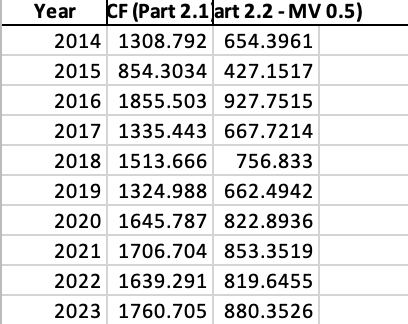

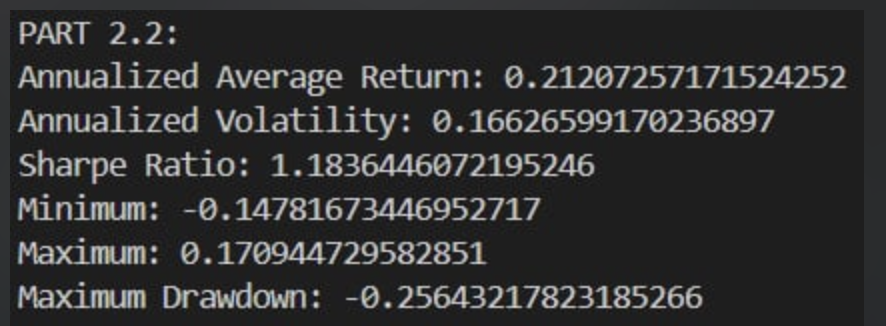

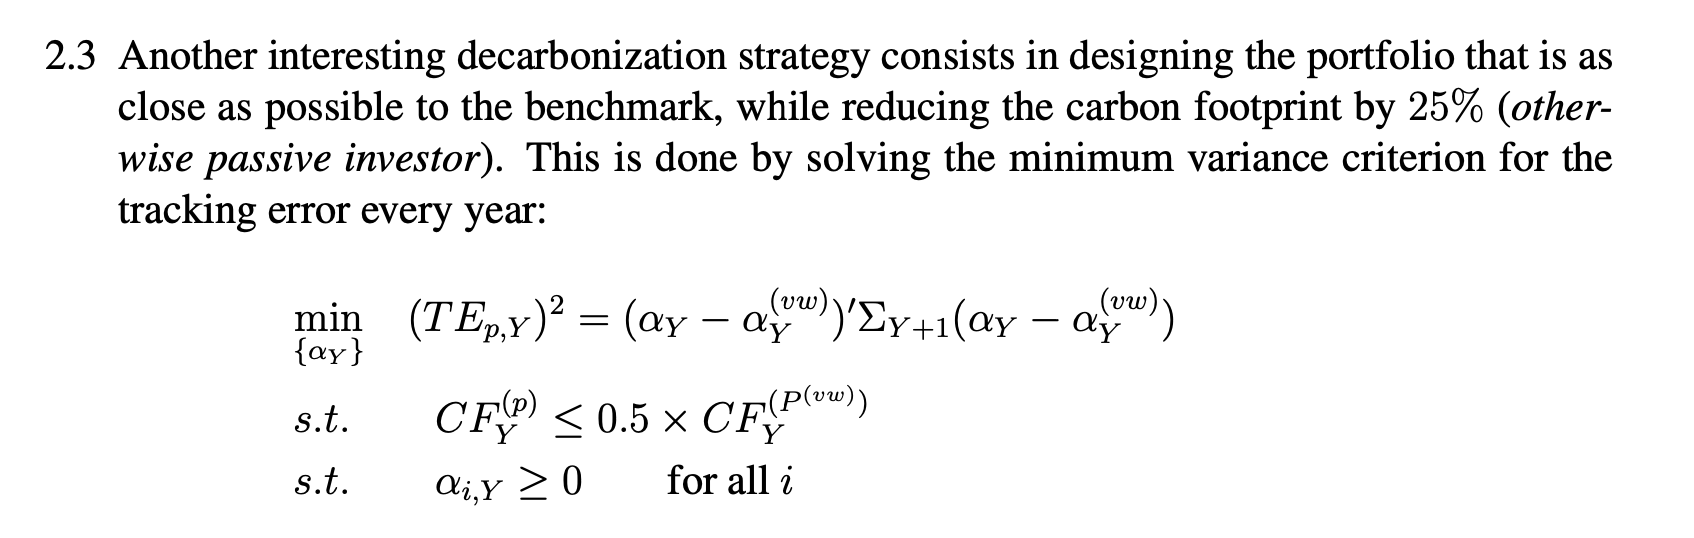

In [ ]:

# === Calculate Value-Weighted Portfolio (VW) Carbon Footprint ===
# Ensure marketcap and scope1 data are correctly aligned by ISIN
common_isins = list(set(marketcap.index) & set(scope1.index))
# Ensure no duplicates in common_isins
common_isins = list(dict.fromkeys(common_isins))

# Create DataFrames with consistent column types
mv_y = pd.DataFrame(index=common_isins)
scope1_y = pd.DataFrame(index=common_isins)

for year in years:
    mv_y[str(year)] = get_column_data(marketcap, year).loc[common_isins]
    scope1_y[str(year)] = get_column_data(scope1, year).loc[common_isins]

# Calculate yearly total market capitalization
yearly_total_mv = mv_y.sum()

# Calculate value-weighted portfolio weights
weights_vw_y = mv_y.div(yearly_total_mv, axis=1)

# Calculate total emissions per year (Scope 1 emissions)
total_emissions_per_year = scope1_y.sum()

# Calculate VW Carbon Footprint (P(VW))
vw_cf = (total_emissions_per_year / yearly_total_mv).rename("Carbon Footprint - P(VW)")

# Display and save the VW Carbon Footprint
print("Value-Weighted Portfolio Carbon Footprint (P(VW)) per year:")
print(vw_cf)

# Save VW Carbon Footprint to Excel
df_vw_cf = pd.DataFrame({
    "Year": years,
    "Carbon Footprint - P(VW)": vw_cf.values
})
df_vw_cf.to_excel("VW_Carbon_Footprint.xlsx", index=False)

# === Initialize Parameters ===
V_init = 1_000_000
years = list(range(2014, 2024))
optimized_weights_2_3 = pd.DataFrame(index=marketcap.index.drop_duplicates(), columns=[str(y) for y in years])


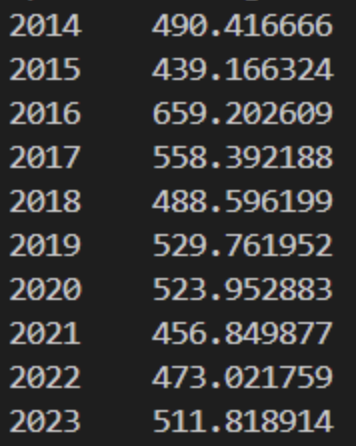

In [ ]:

# === Optimize Tracking Error for Part 2.3 ===
def optimize_for_year(year, target_reduction=0.5):
    print(f"\nOptimizing for year: {year}")
    common_isins = list(set(marketcap.index) & set(scope1.index))
    # Ensure no duplicates in common_isins
    common_isins = list(dict.fromkeys(common_isins))

    # Create DataFrame with explicit index to avoid reindexing issues
    emi_series = get_column_data(scope1, year).loc[common_isins]
    cap_series = get_column_data(marketcap, year).loc[common_isins]

    # Create a new index that's guaranteed to be unique
    valid_indices = emi_series.index.intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    # === Remove Duplicates ===
    initial_count = len(df_tmp)
    df_tmp = df_tmp[~df_tmp.index.duplicated(keep='first')]
    duplicate_count = initial_count - len(df_tmp)
    if duplicate_count > 0:
        print(f"⚠️ Removed {duplicate_count} duplicate ISINs for year {year}.")

    if df_tmp.empty:
        print(f"⚠️ No data for year {year}. Skipping.")
        return

    vw_weights = df_tmp['cap'] / df_tmp['cap'].sum()
    initial_weights = vw_weights.values.copy()  # Start with VW weights

    def tracking_error(w):
        return np.sum((w - vw_weights.values) ** 2)

    def carbon_constraint(w):
        CF = np.sum((w * V_init / df_tmp['cap'].values) * df_tmp['emi'].values) / V_init
        CF_vw = (df_tmp['emi'].sum() / df_tmp['cap'].sum())
        return (target_reduction * CF_vw) - CF

    bounds = [(0, 1)] * len(df_tmp)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'ineq', 'fun': carbon_constraint})

    result = minimize(tracking_error, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'maxiter': 1000})

    if result.success:
        optimized_subset = pd.Series(result.x, index=df_tmp.index)
        optimized_weights_2_3.loc[df_tmp.index, str(year)] = optimized_subset
        print(f" Optimization successful for year {year}.")
    else:
        print(f" Optimization failed for year {year}. Retrying with relaxed constraint.")
        if target_reduction > 0.4:
            optimize_for_year(year, target_reduction - 0.05)
        else:
            print(f" Could not optimize for year {year} after multiple attempts.")

# === Run Optimization for All Years ===
for year in years:
    optimize_for_year(year)

# === Save Optimized Weights ===
optimized_weights_2_3.to_excel("Optimized_Weights_Part_2_3_Debug.xlsx", index=True)

print("Optimized Weights for Part 2.3 saved.")

# Ensure common_isins is defined before using it
common_isins = list(set(marketcap.index) & set(scope1.index))
# Ensure no duplicates in common_isins
common_isins = list(dict.fromkeys(common_isins))

mv05_cf = []
for year in years:
    # Create DataFrame with explicit index to avoid reindexing issues
    try:
        w_series = optimized_weights_2_3.loc[common_isins, str(year)]
        emi_series = get_column_data(scope1, year).loc[common_isins]
        cap_series = get_column_data(marketcap, year).loc[common_isins]
    except Exception as e:
        print(f"Error accessing data for year {year}: {e}")
        mv05_cf.append(np.nan)
        continue

    # Create a new index that's guaranteed to be unique
    valid_indices = w_series.index.intersection(emi_series.index).intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['w'] = w_series.loc[valid_indices]
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    if len(df_tmp) == 0:
        print(f"Warning: No valid data for year {year} in CF calculation 2.3")
        mv05_cf.append(np.nan)
        continue

    V_i = df_tmp['w'].values * V_init
    o_i = V_i / df_tmp['cap'].values
    cf = (1 / V_init) * np.nansum(o_i * df_tmp['emi'].values)
    mv05_cf.append(cf)
    print(f"CF 2.3 for year {year}: {cf:.2f}")

print(pd.concat([pd.Series(mv05_cf, index=years, name="VW 0.5 CF"), pd.Series(vw_cf.values, index=years, name="VW CF"), pd.Series(waci_list, index=years, name="WACI")], axis=1))

risk_free = pd.read_excel("Risk_Free_Rate.xlsx", index_col=0)

# Convert to strings for the from_weights_to_alphas function which expects strings
performances_vw05 = from_alphas_to_perf(from_weights_to_alphas(optimized_weights_2_3))

pf_characteristics(performances_vw05, risk_free, "pmv")


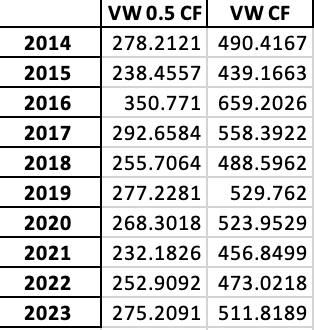

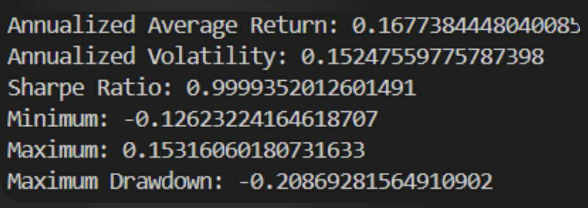

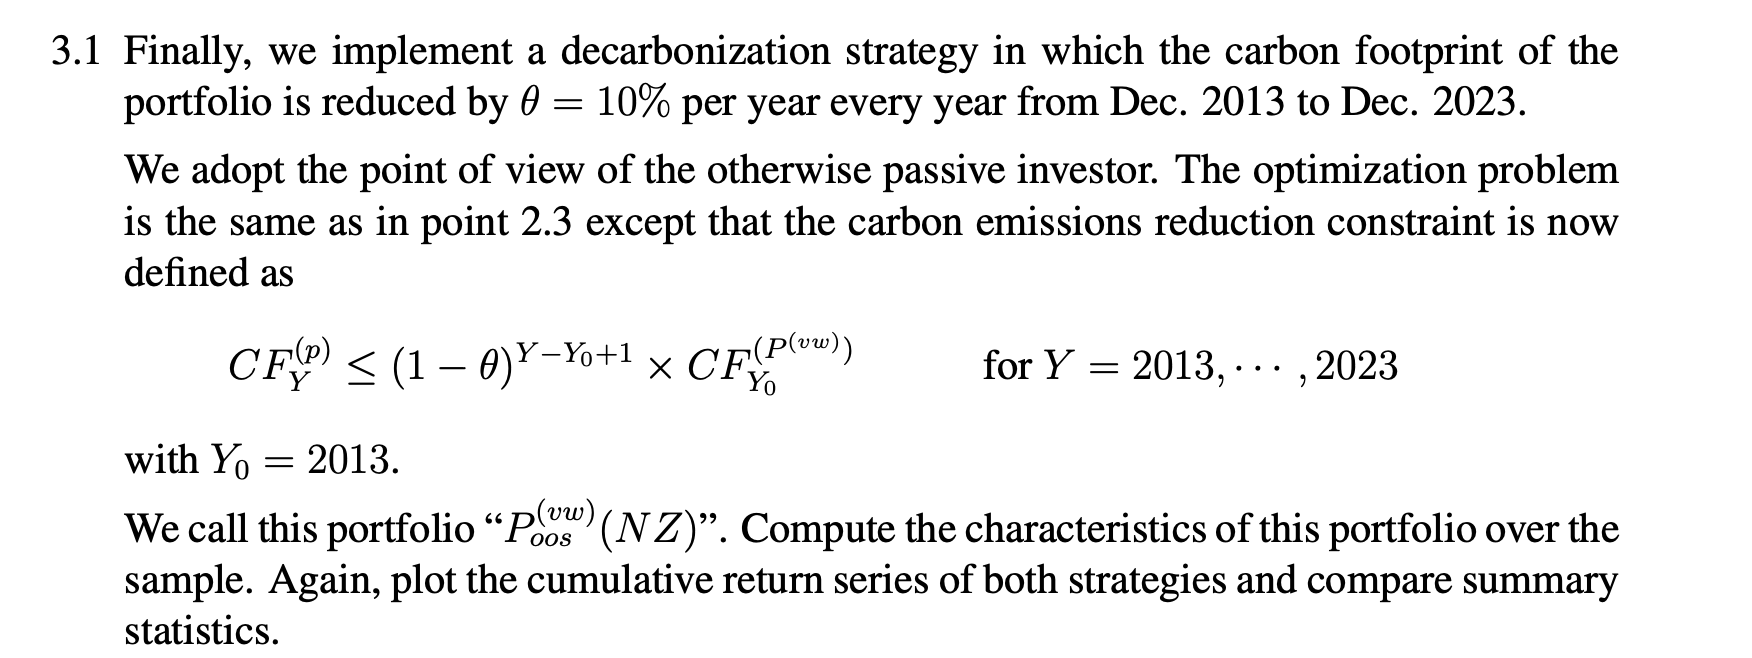

In [ ]:

# === Optimized Weights for Part 3.1 (Net Zero) ===
optimized_weights_3_1 = pd.DataFrame(index=marketcap.index.drop_duplicates(), columns=[str(y) for y in years])

# === Optimize for Net Zero Strategy ===
def optimize_net_zero(year, target_reduction=0.9):
    print(f"\nOptimizing Net Zero for year: {year}")
    common_isins = list(set(marketcap.index) & set(scope1.index))

    # Create DataFrame with explicit index to avoid reindexing issues
    emi_series = get_column_data(scope1, year).loc[common_isins]
    cap_series = get_column_data(marketcap, year).loc[common_isins]

    # Create a new index that's guaranteed to be unique
    valid_indices = emi_series.index.intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    if df_tmp.empty:
        print(f" No data for year {year}. Skipping.")
        return

    # Calculate value-weighted weights for this subset
    vw_weights = df_tmp['cap'] / df_tmp['cap'].sum()
    initial_weights = vw_weights.values.copy()  # Start with VW weights

    # Calculate the base CF for value-weighted portfolio
    CF_vw = df_tmp['emi'].sum() / df_tmp['cap'].sum()

    # Calculate the target CF with reduction factor
    reduction_factor = target_reduction ** (year - 2014 + 1)
    CF_target = reduction_factor * CF_vw

    print(f"Base VW CF: {CF_vw:.2f}")
    print(f"Target CF: {CF_target:.2f}")
    print(f"Reduction factor: {reduction_factor:.4f}")

    def tracking_error(w):
        return np.sum((w - vw_weights.values) ** 2)

    def carbon_constraint(w):
        # Calculate portfolio carbon footprint using the same formula as other portfolios
        CF = np.sum((w * V_init / df_tmp['cap'].values) * df_tmp['emi'].values) / V_init
        # Return difference between target and actual (positive means constraint is satisfied)
        return CF_target - CF

    bounds = [(0, 1)] * len(df_tmp)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'ineq', 'fun': carbon_constraint})

    result = minimize(tracking_error, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'maxiter': 1000})

    if result.success:
        optimized_subset = pd.Series(result.x, index=df_tmp.index)
        optimized_weights_3_1.loc[df_tmp.index, str(year)] = optimized_subset

        # Calculate and print the achieved CF
        w_opt = result.x
        CF_achieved = np.sum((w_opt * V_init / df_tmp['cap'].values) * df_tmp['emi'].values) / V_init
        print(f" Optimization successful for year {year}.")
        print(f"Achieved CF: {CF_achieved:.2f}")
    else:
        print(f" Optimization failed for year {year}. Retrying with relaxed constraint.")
        if target_reduction > 0.8:
            optimize_net_zero(year, target_reduction - 0.05)
        else:
            print(f" Could not optimize for year {year} after multiple attempts.")

# === Run Optimization for All Years ===
for year in years:
    optimize_net_zero(year)

# === Save Optimized Weights ===
optimized_weights_3_1.to_excel("Optimized_Weights_Part_3_1.xlsx", index=True)

print("Optimized Weights for Part 3.1 (Net Zero) saved.")

# Calculate carbon footprint for the Net Zero portfolio
vwnz_cf = []
for year in years:
    # Create DataFrame with explicit index to avoid reindexing issues
    try:
        w_series = optimized_weights_3_1.loc[common_isins, str(year)]
        emi_series = get_column_data(scope1, year).loc[common_isins]
        cap_series = get_column_data(marketcap, year).loc[common_isins]
    except Exception as e:
        print(f"Error accessing data for year {year}: {e}")
        vwnz_cf.append(np.nan)
        continue

    # Create a new index that's guaranteed to be unique
    valid_indices = w_series.index.intersection(emi_series.index).intersection(cap_series.index)

    # Create DataFrame with only valid indices
    df_tmp = pd.DataFrame(index=valid_indices)
    df_tmp['w'] = w_series.loc[valid_indices]
    df_tmp['emi'] = emi_series.loc[valid_indices]
    df_tmp['cap'] = cap_series.loc[valid_indices]
    df_tmp = df_tmp.dropna()

    if len(df_tmp) == 0:
        print(f"Warning: No valid data for year {year} in CF calculation 3.1")
        vwnz_cf.append(np.nan)
        continue

    # Calculate carbon footprint using the same formula as other portfolios
    V_i = df_tmp['w'].values * V_init
    o_i = V_i / df_tmp['cap'].values
    cf = (1 / V_init) * np.nansum(o_i * df_tmp['emi'].values)
    vwnz_cf.append(cf)
    print(f"CF 3.1 (Net Zero) for year {year}: {cf:.2f}")

# Print all carbon footprints for comparison
print("\nCarbon Footprint Comparison:")
comparison_df = pd.concat([
    pd.Series(mv05_cf, index=years, name="VW 0.5 CF"),
    pd.Series(vw_cf.values, index=years, name="VW CF"),
    pd.Series(vwnz_cf, index=years, name="P(VW)(NZ)")
], axis=1)
print(comparison_df)

# Save comparison to Excel
comparison_df.to_excel("Carbon_Footprint_Comparison.xlsx")

# Convert to strings for the from_weights_to_alphas function which expects strings
performances_vwnz = from_alphas_to_perf(from_weights_to_alphas(optimized_weights_3_1))

pf_characteristics(performances_vwnz, risk_free, "pmv")



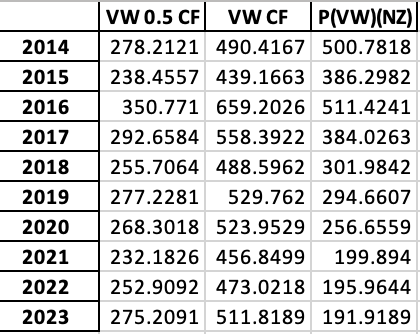

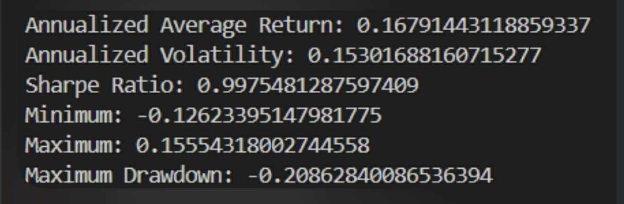